In [1]:
import sys
import os
import glob
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 20, 'display.max_columns', 50)
import h5py
import matplotlib
import matplotlib.pyplot as plt
import seaborn
import re

In [2]:
sys.path.append(os.getcwd() + "/../../cds-backend/code/")
import cds_eua4 as eua

matplotlib.rcParams.update({"font.size": 20})
matplotlib.rcParams["figure.figsize"] = (12, 6)

no config found


In [3]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]


In [4]:
with eua.CDMDataset(glob.glob("/users/staff/uvoggenberger/scratch/mauritius/*vais*.nc")[0]) as file:
    display(file)
    df_vais = file.to_dataframe(groups=['observations_table'], variables=['observation_value', 'observed_variable', 'date_time', 'z_coordinate', 'report_id'])
    df_vais = df_vais[df_vais.observed_variable == 126]
with eua.CDMDataset('/users/staff/uvoggenberger/scratch/mauritius/0-20000-0-61995_mauritius_harvested_meisei_ascents.csv.nc') as file:
    display(file)
    df_meis = file.to_dataframe(groups=['observations_table'], variables=['observation_value', 'observed_variable', 'date_time', 'z_coordinate', 'report_id'])
    df_meis = df_meis[df_meis.observed_variable == 126]


File: <HDF5 file "0-20000-0-61995_mauritius_harvested_vaisala_ascents.csv.nc" (mode r)>
Filesize: 5.95 MB
Filename: /users/staff/uvoggenberger/scratch/mauritius/0-20000-0-61995_mauritius_harvested_vaisala_ascents.csv.nc
(G)roups/(V)ariables: 

 - G | crs__________________________________________ : : 4
 - V | dateindex____________________________________ : : (9,)
 - G | header_table_________________________________ : : 54
 - G | observations_table___________________________ : : 52
 - G | observed_variable____________________________ : : 9
 - V | recordindex__________________________________ : : (56,)
 - V | recordtimestamp______________________________ : : (56,)
 - G | sensor_configuration_________________________ : : 0
 - G | source_configuration_________________________ : : 32
 - G | station_configuration________________________ : : 44
 - G | station_configuration_codes__________________ : : 7
 - G | station_type_________________________________ : : 4
 - G | units_____________________

File: <HDF5 file "0-20000-0-61995_mauritius_harvested_meisei_ascents.csv.nc" (mode r)>
Filesize: 11.80 MB
Filename: /users/staff/uvoggenberger/scratch/mauritius/0-20000-0-61995_mauritius_harvested_meisei_ascents.csv.nc
(G)roups/(V)ariables: 

 - G | crs__________________________________________ : : 4
 - V | dateindex____________________________________ : : (9,)
 - G | header_table_________________________________ : : 54
 - G | observations_table___________________________ : : 53
 - G | observed_variable____________________________ : : 9
 - V | recordindex__________________________________ : : (250268,)
 - V | recordtimestamp______________________________ : : (250268,)
 - G | sensor_configuration_________________________ : : 0
 - G | source_configuration_________________________ : : 32
 - G | station_configuration________________________ : : 44
 - G | station_configuration_codes__________________ : : 7
 - G | station_type_________________________________ : : 4
 - G | units______________

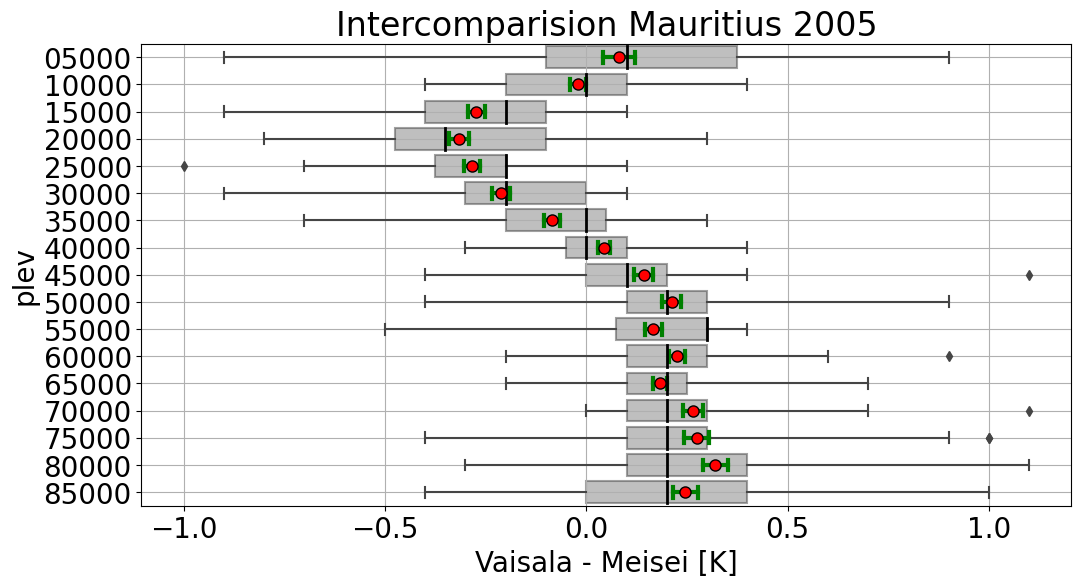

In [35]:
out = {'Difference':[], 'plev': []}
diffs = []
for i in df_vais.date_time.drop_duplicates():
    # print(i.date())
    meis_time = df_meis[df_meis.date_time.dt.date == i.date()]
    for j in meis_time.report_id.drop_duplicates():
        mt = meis_time[meis_time.report_id == j].date_time.iloc[0]
        dh = float((i-mt)/ np.timedelta64(1, 'h'))
        if np.logical_and( dh < -3, dh > -5):
            # print(i, mt, "delta hours: ", dh)
            # print(j)
            # print()
            m_data = df_meis[df_meis.report_id == j]
            v_data = df_vais[df_vais.date_time == i]
            for plev in range(5000, 90000,5000):
                diffs.append(v_data[v_data.z_coordinate == find_nearest(v_data.z_coordinate, plev)].iloc[0].observation_value - m_data[m_data.z_coordinate == find_nearest(m_data.z_coordinate, plev)].iloc[0].observation_value)
                out['Difference'].append(diffs[-1])
                out['plev'].append(str(plev))

df_in = pd.DataFrame.from_dict(out)
df_in.plev = df_in.plev.str.zfill(5)
df_in = df_in.sort_values(by="plev")

for i in zip(
    [
        "Difference",
    ],
    ["grey"],
):
    q3, q1 = np.percentile(df_in[i[0]].dropna(), [75 ,25])
    iqr = q3 - q1
    df_in[i[0]] = df_in[i[0]][np.logical_and(df_in[i[0]] < 3*iqr, df_in[i[0]] > -3*iqr)]
    ax = seaborn.boxplot(
        data=df_in,
        x=i[0],
        y="plev",
        notch=False,
        showcaps=True,
        # fliersize = 100,
        showfliers=True,
        dodge=False,
        showmeans=True,
        boxprops={"facecolor": i[1], "alpha": 0.5},
        medianprops={"color": 'black', "linewidth": 2,},
        meanprops={
            "marker": "o",
            "markerfacecolor": "red",
            "markeredgecolor": "black",
            "markersize": "8",
        },
        whis=3,
        # whis=1.5,
    )
    kwargs = {'alpha':0}
    ax = seaborn.barplot(data=df_in, x=i[0], y="plev", capsize=.4, errorbar=('sd',float(1.96/np.sqrt(len(df_in[i[0]])))), errwidth=3, errcolor='green', **kwargs)
    ax.set_title('Intercomparision Mauritius 2005')
    ax.set_xlabel('Vaisala - Meisei [K]')
    # ax = seaborn.barplot(data=df_in, x=i[0], y="plev", capsize=.2, n_boot=len(df_in[i[0]]), errorbar=('ci',95), errwidth=3, errcolor='blue', **kwargs)
    plt.grid()
    plt.show()
    plt.close()

In [6]:
# calc mean for each level
mean_2005 = df_in.groupby('plev').mean()
mean_2005 = mean_2005.sort_values(by='plev')
mean_2005

,Difference
plev,
05000,0.081818
10000,-0.020002
15000,-0.273080
20000,-0.315385
25000,-0.284616
30000,-0.211110
35000,-0.085185
40000,0.044446
45000,0.142312


In [43]:
ci_2005 = df_in.groupby('plev').std() * float(1.96/np.sqrt(len(df_in['Difference'])))

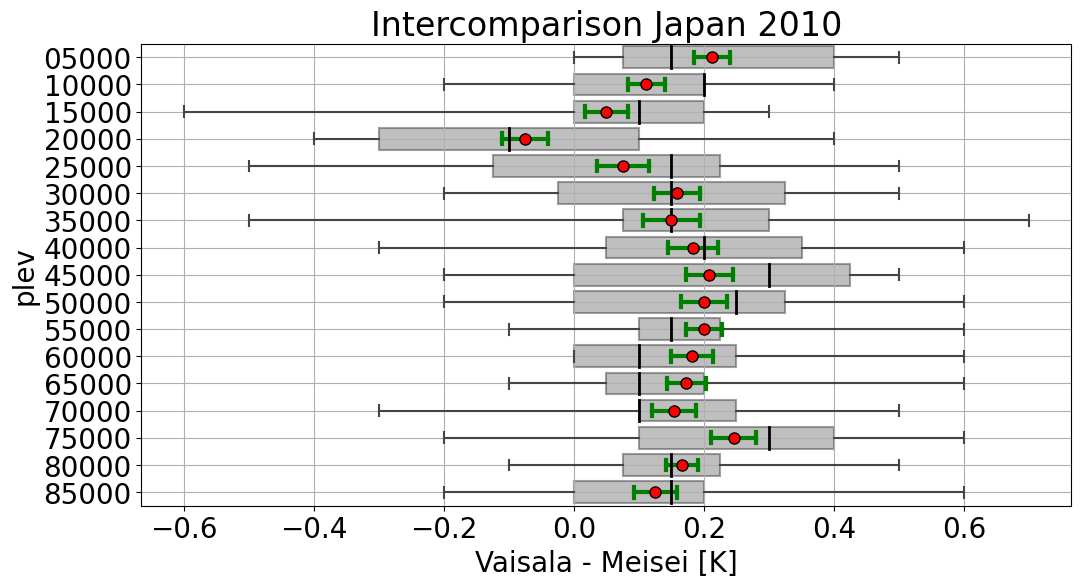

In [36]:
data_cleaned = {}
plevs = {}


for asc in np.sort(glob.glob('/users/staff/uvoggenberger/CEUAS/CEUAS/public/intercomparisons/DATA/Vaisala/*')):
    try:
        ascentnr = asc[-3:]
        for i in glob.glob('/users/staff/uvoggenberger/CEUAS/CEUAS/public/intercomparisons/DATA/*/*.'+ascentnr):
            text = open(i, "r", encoding= 'unicode_escape')
            # display(text)

            #join() method combines all contents of 
            # csvfile.csv and formed as a string
            text = ''.join([j for j in text]) 

            # search and replace the contents
            text = text.replace("\t", ",") 
            text = re.sub(" +", ",", text)
            # output.csv is the output file opened in write mode
            x = open('./'+i.split('/')[-1],"w")

            # all the replaced text is written in the output.csv file
            x.writelines(text)
            x.close()

        yang_dfs = []
        for i in glob.glob('./*.'+ascentnr):
            df = pd.read_csv(i, delimiter=',', header=0, encoding= 'unicode_escape')
            # print(i)
            yang_dfs.append(df)

        labels = glob.glob('./*.'+ascentnr)
        compare_to = labels.index([s for s in labels if "Vaisala" in s][0])
        # print(compare_to)

        yang_dfs[compare_to].Pressure = pd.to_numeric(yang_dfs[compare_to].Pressure, errors='coerce')
        yang_dfs[compare_to] = yang_dfs[compare_to].dropna(subset = ['Pressure'])
        yang_dfs[compare_to].Temperature = pd.to_numeric(yang_dfs[compare_to].Temperature, errors='coerce')
        yang_dfs[compare_to] = yang_dfs[compare_to].dropna(subset = ['Temperature'])
        
        for plev_to_check in range(50, 900, 50):
            cp_to = yang_dfs[compare_to][yang_dfs[compare_to].Pressure == find_nearest(yang_dfs[compare_to].Pressure, plev_to_check)]

            for sonde in range(len(labels)):
                label = labels[sonde][2:].split('.')[0]
                if sonde == compare_to:
                    continue

                yang_dfs[sonde].Pressure = pd.to_numeric(yang_dfs[sonde].Pressure, errors='coerce')
                yang_dfs[sonde] = yang_dfs[sonde].dropna(subset = ['Pressure'])
                yang_dfs[sonde].Temperature = pd.to_numeric(yang_dfs[sonde].Temperature, errors='coerce')
                yang_dfs[sonde] = yang_dfs[sonde].dropna(subset = ['Temperature'])

                for press in range(len(cp_to)):
                    delta_t = (
                        cp_to.Temperature.iloc[press]
                        - yang_dfs[sonde][
                            yang_dfs[sonde].Pressure
                            == find_nearest(
                                np.array(yang_dfs[sonde].Pressure),
                                cp_to.Pressure.iloc[press]
                            )
                        ].Temperature.values[0]
                    )
                if label in list(data_cleaned.keys()):
                    data_cleaned[label].append(delta_t)
                    plevs[label].append(str(plev_to_check))
                else:
                    data_cleaned[label]=[delta_t]
                    plevs[label]=[str(plev_to_check)]

    except:
        pass
        # print('error')
        
try: 
    labels.remove('./Vaisala.069')
except: 
    pass

# for i in labels[2]:
i = labels[2]
label = i[2:].split(".")[0]
data_cleaned[label] = np.array(data_cleaned[label])
plevs[label] = np.array(plevs[label])
q3, q1 = np.percentile(data_cleaned[label], [75 ,25])
iqr = q3 - q1
plevs[label] = plevs[label][np.logical_and(data_cleaned[label] < 3*iqr, data_cleaned[label] > -3*iqr)]
data_cleaned[label] = data_cleaned[label][np.logical_and(data_cleaned[label] < 3*iqr, data_cleaned[label] > -3*iqr)]

dfin_2010 = pd.DataFrame.from_dict({'Difference': data_cleaned[label], 'plev': [(i + '00').zfill(5) for i in plevs[label]]})
dfin_2010 = dfin_2010.sort_values(by='plev')

ax = seaborn.boxplot(
    x=dfin_2010['Difference'],
    y=dfin_2010['plev'],
    notch=False,
    showcaps=True,
    showfliers=True,
    dodge=False,
    boxprops={"facecolor": "grey", "alpha": 0.5},
    medianprops={"color": "black", "linewidth": 2},
    meanprops={
        "marker": "o",
        "markerfacecolor": "red",
        "markeredgecolor": "black",
        "markersize": "8",
    },
    showmeans =  True, 
    whis=np.inf,
    # whis=1.5,
)
kwargs = {'alpha':0}
ax = seaborn.barplot(x=dfin_2010['Difference'], y=dfin_2010['plev'], capsize=.4,  errorbar=('sd',float(1.96/np.sqrt(len(dfin_2010['Difference'])))), errwidth=3, errcolor='green', **kwargs)
ax.set_xlabel('Vaisala - Meisei [K]')
ax.set_title('Intercomparison Japan 2010')
# ax = seaborn.barplot(x=data_cleaned[label], y=plevs[label], capsize=.2, n_boot=len(data_cleaned[label]), errorbar=('ci',95), errwidth=3, errcolor='blue', **kwargs)
# ax = seaborn.barplot(x=data_cleaned[label], y=plevs[label], capsize=.2, n_boot=len(data_cleaned[label]), errorbar=('pi',90), errwidth=3, **kwargs)
plt.grid()
plt.show()
plt.close()

In [47]:
ci_2010 = dfin_2010.groupby('plev').std() * float(1.96/np.sqrt(len(dfin_2010['Difference'])))

In [8]:
# calc mean for each level
mean_2010 = dfin_2010.groupby('plev').mean().sort_values(by='plev')
mean_2010

,Difference
plev,
05000,0.212500
10000,0.111111
15000,0.050000
20000,-0.075000
25000,0.075000
30000,0.158333
35000,0.150000
40000,0.183333
45000,0.208333


In [9]:
# diff of mean of both -> diff between 01 and 06

In [10]:
diff_df = mean_2005 - mean_2010
diff_df

,Difference
plev,
05000,-0.130682
10000,-0.131113
15000,-0.323080
20000,-0.240385
25000,-0.359616
30000,-0.369444
35000,-0.235185
40000,-0.138887
45000,-0.066022


In [52]:
ci_diff = np.sqrt(ci_2010**2 + ci_2005**2)

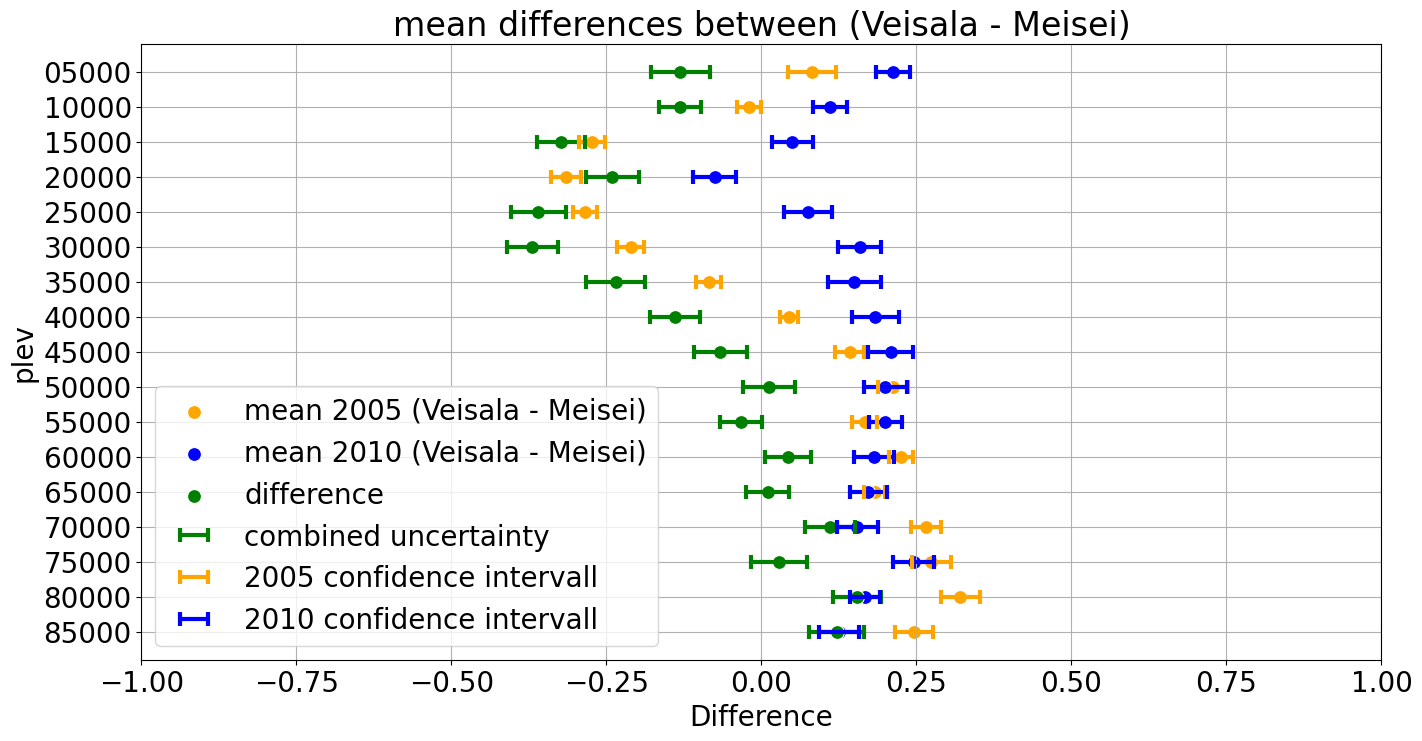

In [85]:
fig, ax = plt.subplots(1, figsize=(16, 8))
seaborn.scatterplot(x=mean_2005.Difference, y=mean_2005.index, s=100, label='mean 2005 (Veisala - Meisei)', color='orange')
seaborn.scatterplot(x=mean_2010.Difference, y=mean_2010.index, s=100, label='mean 2010 (Veisala - Meisei)', color='blue')
seaborn.scatterplot(x=diff_df.Difference, y = diff_df.index, color='green', s=100, label='difference')
(_, caps0, _) = plt.errorbar(x=diff_df.Difference, y = diff_df.index, xerr=np.array(ci_diff).flatten(), color='green', label='combined uncertainty', capsize=5, elinewidth=3, linestyle='', )
for cap in caps0:
    cap.set_markeredgewidth(3)
(_, caps1, _) = plt.errorbar(x=mean_2005.Difference, y=mean_2005.index, xerr=np.array(ci_2005).flatten(), color='orange', label='2005 confidence intervall', capsize=5, elinewidth=3, linestyle='', )
for cap in caps1:
    cap.set_markeredgewidth(3)
(_, caps2, _) = plt.errorbar(mean_2010.Difference, y=mean_2010.index, xerr=np.array(ci_2010).flatten(), color='blue', label='2010 confidence intervall', capsize=5, elinewidth=3, linestyle='', )
for cap in caps2:
    cap.set_markeredgewidth(3)

ax.set_xlim([-1,1])
ax.set_title('mean differences between (Veisala - Meisei)')
plt.legend()
plt.grid()
plt.show()